In [1]:
import sqlite3
import emailer
import yelp_api_grabber as grabber
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import selenium.webdriver.support.ui as sui
from bs4 import BeautifulSoup
import requests 
import re
import pandas as pd
import time
import numpy as np
import smtplib, ssl
import email.utils
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
import getpass
import base64
import reverse_geocode
%load_ext autoreload
%autoreload 2

Password:
········


In [330]:
def get_main_page_link(search_by="class", search_term="ca-h3"):
    usuable_links = []
    links = soup.findAll('div')
    for link in links:
        try:
            if search_term in link[search_by]:
                usuable_links.append(link["i-stars"])
        except:
            continue
    return usuable_links

for link in links:
    try:
        if "ca-h3" in link["class"]:
            print(link["href"])
    except:
        print("No Class")

# Gathering Data From Yelp based of Term Tutoring

In [34]:
client_id = '5onuGByRauHpN8oN0PEgtw' #Your client ID goes here (as a string)
api_key = 'Ystbu1NrD08vSyMfFl5XxExXnikbKXwv-MtJRUHCSQNjTYWTSpsn7SRkLQUoVE9nf1nr_JCD7oD9kCjQIgMGQbxKFF-HwpB0dresyDzXqx-nztbSq4rhrVq0MHJcXHYx'


def get_all_info(search_term, location):    
    data = []
    term = search_term
    location = location
    SEARCH_LIMIT = 50
    sort_by = "review_count"
    offset = 0
    search_count = SEARCH_LIMIT

    url = 'https://api.yelp.com/v3/businesses/search'

    headers = {
            'Authorization': 'Bearer {}'.format(api_key),
        }
    count = 0
    while search_count >= 0:
        url_params = {
                        'term': term.replace(' ', '+'),
                        'location': location.replace(' ', '+'),
                        'sort_by':sort_by,
                        'limit': SEARCH_LIMIT,
                        'offset':offset
                    }
        yelp_api = requests.get(url, headers=headers, params=url_params)
        data.append(yelp_api.json())
        offset += SEARCH_LIMIT
        search_count = data[0]["total"] - offset
        count += 1
        if count % 100 == 0:
            print(count)
    return data
# data4 = get_all_info()

In [37]:
def gather_api_data(terms, location):
    data = []
    for term in terms:
        print(term)
        data.extend(get_all_info(term, location))
        time.sleep(1)
    return data

In [40]:
terms = ["test prep", "after school", "tutoring", "learning center", "math", "ela", "homework help"]

In [42]:
dataNYC = gather_api_data(terms, "NYC")
dataUpstate = gather_api_data(terms, "Rochester")
dataJerseyCity = gather_api_data(terms, "Jersey City")
dataNorwalk = gather_api_data(terms,"Norwalk")
dataNewark = gather_api_data(terms, "Newark")
dataNewHaven = gather_api_data(terms, "New Haven")

test prep
after school
tutoring
learning center
math
ela
homework help
test prep
after school
tutoring
learning center
math
ela
homework help
test prep
after school
tutoring
learning center
math
ela
homework help
test prep
after school
tutoring
learning center
math
ela
homework help
test prep
after school
tutoring
learning center
math
ela
homework help
test prep
after school
tutoring
learning center
math
ela
homework help


In [43]:
api_data = dataNYC + dataJerseyCity + dataNewark + dataNewHaven + dataNorwalk + dataUpstate

In [45]:
def clean_yelp_search(data):
    info = []
    for datum in data:
        if "businesses" in datum:
            for d in datum["businesses"]:
                d["categories"] = list(np.array(d["categories"]).flatten())
            info.extend(datum["businesses"])
    return pd.DataFrame(info)

In [46]:
clean_df_tri_state = clean_yelp_search(api_data)

In [48]:
clean_df_tri_state.shape

(9284, 16)

### Shape is 736 before initial clean. We will need to add more companies

In [49]:
def collapse_feature(df, features):
    features_df1 = df.copy()
    for feature in features:
        try:
            feature_df = df[feature].apply(pd.Series)
            col = [f"{feature}_{i}" for i in range(0, len(feature_df.columns))]
            feature_df.columns =  col
            features_df1 = pd.concat([features_df1, feature_df], axis = 1)
            features_df1.drop([feature], axis=1, inplace=True)
        except:
            print(f"No feature: {feature}")
    return features_df1

In [107]:
df_tri_state = collapse_feature(clean_df_tri_state, ["categories", "location", "coordinates"])

In [108]:
df_tri_state["coordinates"] = tuple(zip(df_tri_state.coordinates_0, df_tri_state.coordinates_1))

In [110]:
df_tri_state.drop(["location_7", "distance", "image_url", "alias", "coordinates_0", 
                   "coordinates_1", "transactions"], axis=1, inplace=True)


In [111]:
df_tri_state.shape

(9284, 21)

In [112]:
df_tri_state.columns

Index(['display_phone', 'id', 'is_closed', 'name', 'phone', 'price', 'rating',
       'review_count', 'url', 'categories_0', 'categories_1', 'categories_2',
       'categories_3', 'location_0', 'location_1', 'location_2', 'location_3',
       'location_4', 'location_5', 'location_6', 'coordinates'],
      dtype='object')

In [113]:
def set_up_categories(df, categories):
    df1 = df.copy()
    count = 0
    for category in categories:
        df_change = df[category].apply(pd.Series)
        df_change.drop([0], axis=1, inplace=True)
        df_change.columns = [f'{col}_{count}' for col in df_change.columns]
        count += 1
        df1 = pd.concat([df1, df_change], axis=1)
    df1.drop(categories, axis=1, inplace=True)
    return df1

In [114]:
df_tri_state1 = set_up_categories(df_tri_state, ['categories_0', 'categories_1','categories_2', 'categories_3'])

In [115]:
print(df_tri_state1.shape)

(9284, 25)


In [117]:
df_tri_state1

,display_phone,id,is_closed,name,phone,price,rating,review_count,url,location_0,...,location_6,coordinates,alias_0,title_0,alias_1,title_1,alias_2,title_2,alias_3,title_3
0,(718) 939-6969,adtO07N6BEgIbcsW6x77HA,False,Learn-Rite Driving School,+17189396969,NaN,4.5,213,https://www.yelp.com/biz/learn-rite-driving-sc...,136-18 35th Ave,...,NY,"(40.7647718, -73.8298022)",driving_schools,Driving Schools,NaN,NaN,NaN,NaN,NaN,NaN
1,(718) 595-1999,Hh9mSYYFRCNU_ns7oQ2lEQ,False,Gold Success Driving School,+17185951999,NaN,4.5,179,https://www.yelp.com/biz/gold-success-driving-...,83-21 Broadway,...,NY,"(40.74083, -73.87926)",driving_schools,Driving Schools,NaN,NaN,NaN,NaN,NaN,NaN
2,(718) 928-7048,dfBHip_0UkFF3oYLQcHt0w,False,Drive Rite Academy,+17189287048,NaN,4.5,128,https://www.yelp.com/biz/drive-rite-academy-br...,145 Kenilworth Pl,...,NY,"(40.6327095031738, -73.9484634399414)",driving_schools,Driving Schools,NaN,NaN,NaN,NaN,NaN,NaN
3,(212) 721-7400,zv-tJy03CCqZA1OZ05gJCQ,False,Manhattan Prep,+12127217400,NaN,4.5,100,https://www.yelp.com/biz/manhattan-prep-new-yo...,138 West 25th St,...,NY,"(40.744855, -73.993467)",tutoring,Tutoring Centers,testprep,Test Preparation,privatetutors,Private Tutors,NaN,NaN
4,(888) 427-7737,mjncjh-zqgzwFLP3wTL8TQ,False,Blueprint LSAT Preparation,+18884277737,NaN,4.5,42,https://www.yelp.com/biz/blueprint-lsat-prepar...,594 Broadway,...,NY,"(40.7249640244489, -73.996914315358)",tutoring,Tutoring Centers,testprep,Test Preparation,NaN,NaN,NaN,NaN
5,(646) 434-1084,6z63xLs8i0a-R1FMrzL-zw,False,Bright Kids NYC,+16464341084,NaN,3.5,34,https://www.yelp.com/biz/bright-kids-nyc-new-y...,225 Broadway,...,NY,"(40.71188, -74.00842)",tutoring,Tutoring Centers,NaN,NaN,NaN,NaN,NaN,NaN
6,(800) 925-7737,tiJtgi0vAQULwzVmJDankg,False,Veritas Prep,+18009257737,NaN,4.5,22,https://www.yelp.com/biz/veritas-prep-new-york...,29 W 17th St,...,NY,"(40.73866, -73.99374)",tutoring,Tutoring Centers,testprep,Test Preparation,privatetutors,Private Tutors,NaN,NaN
7,(800) 696-5728,dL6McPbcQXFSOrY5cbMp7Q,False,TestMasters,+18006965728,NaN,5.0,19,https://www.yelp.com/biz/testmasters-new-york?...,109 East 42nd St,...,NY,"(40.7527038, -73.9934785)",testprep,Test Preparation,NaN,NaN,NaN,NaN,NaN,NaN
8,(646) 653-5027,d7RyP2D8soB6gSZXnrrAvg,False,TPU GMAT Tutoring Score Guarantee NYC,+16466535027,NaN,5.0,17,https://www.yelp.com/biz/tpu-gmat-tutoring-sco...,6 Washington Pl,...,NY,"(40.75243, -73.9737387)",testprep,Test Preparation,tutoring,Tutoring Centers,privatetutors,Private Tutors,NaN,NaN
9,(646) 657-8357,3_dH8gOSbF2CMsh5er3FBg,False,LSAT Blog,+16466578357,NaN,5.0,14,https://www.yelp.com/biz/lsat-blog-new-york-2?...,99 Wall St,...,NY,"(40.70485, -74.00719)",testprep,Test Preparation,privatetutors,Private Tutors,NaN,NaN,NaN,NaN


Find all the unique titles and visually look at the titles that are tutoring related

In [118]:
arr_0_all = df_tri_state1.title_0.unique()
arr_1_all = df_tri_state1.title_1.unique()
arr_2_all = df_tri_state1.title_2.unique()
arr_3_all = df_tri_state1.title_3.unique()
arr_comb_all = np.union1d(arr_0_all.astype(str), arr_1_all.astype(str))
arr_comb_all = np.union1d(arr_2_all.astype(str), arr_comb_all)
arr_comb_all = np.union1d(arr_3_all.astype(str), arr_comb_all)

In [120]:
len(arr_comb_all)

452

In [121]:
# get a list of titles that are related to tutoring
def keywords(arr):
    lst = []
    hot_words = ["Tutor", "Child", "Kids", "Education", "Community", "Cultural", "Camps", 
                 "Preschool", "Clubs", "Prep", "Homework"]
    for item in arr:
        for word in hot_words:
            if word in item:
                lst.append(item)
                break
    return lst

In [122]:
len(keywords(arr_comb_all))

25

In [146]:
# checks if the title is related to tutoring or not

 def title_coding(df, titles):
    df_4 = df.copy()
    count = 0
    keys = keywords(arr_comb_all)
    for title in titles:
        encoding = []
        for item in df_4[title].astype(str):
            flag = False
            for key in keys:
                if key in item:
                    encoding.append(1)
                    flag = True
                    break
            if flag == False:
                encoding.append(0)
            else:
                flag = False
        df_4[f"title_{count}_code"] = encoding
        count += 1
    return df_4           
            

In [147]:
df_tri_state2 = title_coding(df_tri_state1, ["title_0", "title_1", "title_2", "title_3"])

In [148]:
df_tri_state2[["name","title_0_code", "title_0", "title_1_code", "title_1", "title_2_code", "title_2", 
          "title_3_code", "title_3"]]

,name,title_0_code,title_0,title_1_code,title_1,title_2_code,title_2,title_3_code,title_3
0,Learn-Rite Driving School,0,Driving Schools,0,NaN,0,NaN,0,NaN
1,Gold Success Driving School,0,Driving Schools,0,NaN,0,NaN,0,NaN
2,Drive Rite Academy,0,Driving Schools,0,NaN,0,NaN,0,NaN
3,Manhattan Prep,1,Tutoring Centers,1,Test Preparation,1,Private Tutors,0,NaN
4,Blueprint LSAT Preparation,1,Tutoring Centers,1,Test Preparation,0,NaN,0,NaN
5,Bright Kids NYC,1,Tutoring Centers,0,NaN,0,NaN,0,NaN
6,Veritas Prep,1,Tutoring Centers,1,Test Preparation,1,Private Tutors,0,NaN
7,TestMasters,1,Test Preparation,0,NaN,0,NaN,0,NaN
8,TPU GMAT Tutoring Score Guarantee NYC,1,Test Preparation,1,Tutoring Centers,1,Private Tutors,0,NaN
9,LSAT Blog,1,Test Preparation,1,Private Tutors,0,NaN,0,NaN


In [150]:
df_tri_state2["counts"] = df_tri_state2["title_0_code"] + df_tri_state2["title_1_code"] + df_tri_state2["title_2_code"] + df_tri_state2["title_3_code"]




In [151]:
df_tri_state3 = df_tri_state2.copy()[df_tri_state2.counts.values > 0]

In [152]:
df_tri_state3.shape

(5594, 30)

In [153]:
df_tri_state3

,display_phone,id,is_closed,name,phone,price,rating,review_count,url,location_0,...,title_1,alias_2,title_2,alias_3,title_3,title_0_code,title_1_code,title_2_code,title_3_code,counts
3,(212) 721-7400,zv-tJy03CCqZA1OZ05gJCQ,False,Manhattan Prep,+12127217400,NaN,4.5,100,https://www.yelp.com/biz/manhattan-prep-new-yo...,138 West 25th St,...,Test Preparation,privatetutors,Private Tutors,NaN,NaN,1,1,1,0,3
4,(888) 427-7737,mjncjh-zqgzwFLP3wTL8TQ,False,Blueprint LSAT Preparation,+18884277737,NaN,4.5,42,https://www.yelp.com/biz/blueprint-lsat-prepar...,594 Broadway,...,Test Preparation,NaN,NaN,NaN,NaN,1,1,0,0,2
5,(646) 434-1084,6z63xLs8i0a-R1FMrzL-zw,False,Bright Kids NYC,+16464341084,NaN,3.5,34,https://www.yelp.com/biz/bright-kids-nyc-new-y...,225 Broadway,...,NaN,NaN,NaN,NaN,NaN,1,0,0,0,1
6,(800) 925-7737,tiJtgi0vAQULwzVmJDankg,False,Veritas Prep,+18009257737,NaN,4.5,22,https://www.yelp.com/biz/veritas-prep-new-york...,29 W 17th St,...,Test Preparation,privatetutors,Private Tutors,NaN,NaN,1,1,1,0,3
7,(800) 696-5728,dL6McPbcQXFSOrY5cbMp7Q,False,TestMasters,+18006965728,NaN,5.0,19,https://www.yelp.com/biz/testmasters-new-york?...,109 East 42nd St,...,NaN,NaN,NaN,NaN,NaN,1,0,0,0,1
8,(646) 653-5027,d7RyP2D8soB6gSZXnrrAvg,False,TPU GMAT Tutoring Score Guarantee NYC,+16466535027,NaN,5.0,17,https://www.yelp.com/biz/tpu-gmat-tutoring-sco...,6 Washington Pl,...,Tutoring Centers,privatetutors,Private Tutors,NaN,NaN,1,1,1,0,3
9,(646) 657-8357,3_dH8gOSbF2CMsh5er3FBg,False,LSAT Blog,+16466578357,NaN,5.0,14,https://www.yelp.com/biz/lsat-blog-new-york-2?...,99 Wall St,...,Private Tutors,NaN,NaN,NaN,NaN,1,1,0,0,2
10,(718) 359-3952,zGOxDwURBJ1edWhKFvtxbg,False,Mega Academy,+17183593952,NaN,2.0,14,https://www.yelp.com/biz/mega-academy-flushing...,13350 41st Ave,...,Test Preparation,NaN,NaN,NaN,NaN,1,1,0,0,2
11,(718) 353-9868,HTNDX9rR0ilEPIbEfTlZaQ,False,Premier Aptitude,+17183539868,NaN,5.0,13,https://www.yelp.com/biz/premier-aptitude-flus...,33-45 Francis Lewis Blvd,...,Tutoring Centers,NaN,NaN,NaN,NaN,1,1,0,0,2
12,(888) 884-5728,xKAU42_Ujs1JU3GS5fcu4Q,False,Binary Solution,+18888845728,NaN,4.0,13,https://www.yelp.com/biz/binary-solution-new-y...,99 Hudson St,...,Test Preparation,NaN,NaN,NaN,NaN,1,1,0,0,2


In [154]:
df_tri_state3.reset_index(inplace=True)
df_tri_state3.drop(["index"], axis=1, inplace=True)
df_tri_state3

,display_phone,id,is_closed,name,phone,price,rating,review_count,url,location_0,...,title_1,alias_2,title_2,alias_3,title_3,title_0_code,title_1_code,title_2_code,title_3_code,counts
0,(212) 721-7400,zv-tJy03CCqZA1OZ05gJCQ,False,Manhattan Prep,+12127217400,NaN,4.5,100,https://www.yelp.com/biz/manhattan-prep-new-yo...,138 West 25th St,...,Test Preparation,privatetutors,Private Tutors,NaN,NaN,1,1,1,0,3
1,(888) 427-7737,mjncjh-zqgzwFLP3wTL8TQ,False,Blueprint LSAT Preparation,+18884277737,NaN,4.5,42,https://www.yelp.com/biz/blueprint-lsat-prepar...,594 Broadway,...,Test Preparation,NaN,NaN,NaN,NaN,1,1,0,0,2
2,(646) 434-1084,6z63xLs8i0a-R1FMrzL-zw,False,Bright Kids NYC,+16464341084,NaN,3.5,34,https://www.yelp.com/biz/bright-kids-nyc-new-y...,225 Broadway,...,NaN,NaN,NaN,NaN,NaN,1,0,0,0,1
3,(800) 925-7737,tiJtgi0vAQULwzVmJDankg,False,Veritas Prep,+18009257737,NaN,4.5,22,https://www.yelp.com/biz/veritas-prep-new-york...,29 W 17th St,...,Test Preparation,privatetutors,Private Tutors,NaN,NaN,1,1,1,0,3
4,(800) 696-5728,dL6McPbcQXFSOrY5cbMp7Q,False,TestMasters,+18006965728,NaN,5.0,19,https://www.yelp.com/biz/testmasters-new-york?...,109 East 42nd St,...,NaN,NaN,NaN,NaN,NaN,1,0,0,0,1
5,(646) 653-5027,d7RyP2D8soB6gSZXnrrAvg,False,TPU GMAT Tutoring Score Guarantee NYC,+16466535027,NaN,5.0,17,https://www.yelp.com/biz/tpu-gmat-tutoring-sco...,6 Washington Pl,...,Tutoring Centers,privatetutors,Private Tutors,NaN,NaN,1,1,1,0,3
6,(646) 657-8357,3_dH8gOSbF2CMsh5er3FBg,False,LSAT Blog,+16466578357,NaN,5.0,14,https://www.yelp.com/biz/lsat-blog-new-york-2?...,99 Wall St,...,Private Tutors,NaN,NaN,NaN,NaN,1,1,0,0,2
7,(718) 359-3952,zGOxDwURBJ1edWhKFvtxbg,False,Mega Academy,+17183593952,NaN,2.0,14,https://www.yelp.com/biz/mega-academy-flushing...,13350 41st Ave,...,Test Preparation,NaN,NaN,NaN,NaN,1,1,0,0,2
8,(718) 353-9868,HTNDX9rR0ilEPIbEfTlZaQ,False,Premier Aptitude,+17183539868,NaN,5.0,13,https://www.yelp.com/biz/premier-aptitude-flus...,33-45 Francis Lewis Blvd,...,Tutoring Centers,NaN,NaN,NaN,NaN,1,1,0,0,2
9,(888) 884-5728,xKAU42_Ujs1JU3GS5fcu4Q,False,Binary Solution,+18888845728,NaN,4.0,13,https://www.yelp.com/biz/binary-solution-new-y...,99 Hudson St,...,Test Preparation,NaN,NaN,NaN,NaN,1,1,0,0,2


In [155]:
df_biz_tri = df_tri_state3.drop_duplicates().reset_index().drop(["index"], axis=1)

In [157]:
df_biz_tri.shape

(2128, 30)

In [159]:
df_biz_tri.to_json("bizdata.json")

In [2]:
df_biz_tri = pd.read_json("bizdata.json")

In [5]:
df_biz_tri = df_biz_tri.reset_index()

In [7]:
df_biz_tri.drop(["index"], axis=1, inplace=True)

In [8]:
df_biz_tri

,display_phone,id,is_closed,name,phone,price,rating,review_count,url,location_0,...,title_1,alias_2,title_2,alias_3,title_3,title_0_code,title_1_code,title_2_code,title_3_code,counts
0,(212) 721-7400,zv-tJy03CCqZA1OZ05gJCQ,False,Manhattan Prep,+12127217400,None,4.5,100,https://www.yelp.com/biz/manhattan-prep-new-yo...,138 West 25th St,...,Test Preparation,privatetutors,Private Tutors,None,None,1,1,1,0,3
1,(888) 427-7737,mjncjh-zqgzwFLP3wTL8TQ,False,Blueprint LSAT Preparation,+18884277737,None,4.5,42,https://www.yelp.com/biz/blueprint-lsat-prepar...,594 Broadway,...,Test Preparation,None,None,None,None,1,1,0,0,2
2,(212) 327-0098,z9qXu4bAn1sz39yYGkgp7Q,False,Med School Tutors,+12123270098,None,4.5,13,https://www.yelp.com/biz/med-school-tutors-new...,555 Fifth Ave,...,Test Preparation,None,None,None,None,1,1,0,0,2
3,(914) 921-6700,3kXRRyEYlSmc94PU1in25g,False,Advantage Testing of Westchester,+19149216700,None,2.5,5,https://www.yelp.com/biz/advantage-testing-of-...,350 Theodore Fremd Ave,...,None,None,None,None,None,1,0,0,0,1
4,(201) 553-2200,6nuVvUQ4KoOKqhZLwfjbJA,False,Look What I Can Do Learning Center,+12015532200,None,4.5,15,https://www.yelp.com/biz/look-what-i-can-do-le...,5600 Kennedy Blvd,...,None,None,None,None,None,1,0,0,0,1
5,(718) 278-7500,lFmxYnXS491dJLz2hG4qHA,False,Diki Discovery Center,+17182787500,None,4.0,9,https://www.yelp.com/biz/diki-discovery-center...,30-16 37th St,...,None,None,None,None,None,1,0,0,0,1
6,(917) 720-2865,T8sy9gRqf5-Ec0Wtq4FhCw,False,Choice Parenting,+19177202865,None,5.0,7,https://www.yelp.com/biz/choice-parenting-jers...,,...,Nanny Services,educationservices,Educational Services,None,None,1,0,1,0,2
7,(718) 646-6272,78v1SCBY7gNygpQhK0d1gQ,False,Butterfly Daycare Center,+17186466272,None,3.0,5,https://www.yelp.com/biz/butterfly-daycare-cen...,2770 E 16th St,...,Preschools,None,None,None,None,1,1,0,0,2
8,(201) 795-1443,tURb4XtTr5NtAWb8qtg8EQ,False,St Elizabeth Child Care Center,+12017951443,None,5.0,5,https://www.yelp.com/biz/st-elizabeth-child-ca...,129 Garrison Ave,...,None,None,None,None,None,1,0,0,0,1
9,(646) 206-9183,IjiUHhvzuaEO48nDeRcoRw,False,Doula Support NYC,+16462069183,None,5.0,5,https://www.yelp.com/biz/doula-support-nyc-new...,928 Broadway,...,Yoga,childbirthedu,Childbirth Education,None,None,0,0,1,0,1


We reduced the our data by almost 100 entries

### Getting Review Data From Yelp

In [9]:
def get_specific_data(driver, class_name, att="title", get_info="class"):
    elems = driver.find_elements_by_class_name(class_name)
    final = []
    if get_info == "att":
        for elem in elems:
            info = elem.get_attribute(att)
            final.append(info)
    else:
        for elem in elems:
            info = elem.text
            final.append(info)
    return final

In [10]:
def get_star_ratings(driver):
    page = driver.page_source
    soup = BeautifulSoup(page)
    meta = soup.findAll("meta")
    stars = []
    for item in str(meta).split("<meta content="):
        if "ratingValue" in item:
            try:
                stars.append(float(item.strip(' itemprop="ratingValue"/>, ')))
            except:
                continue
    return stars

In [11]:
def get_certain_data(driver, subj):
    page = driver.page_source
    soup = BeautifulSoup(page)
    meta = soup.findAll("meta")
    data = []
    for item in str(meta).split("<meta content="):
        if subj in item:
            try:
                data.append(item.strip(f' itemprop="{subj}"/>, '))
            except:
                continue
    return data

In [12]:
def get_user_name(driver):
    page = driver.page_source
    soup = BeautifulSoup(page)
    meta = soup.findAll("meta")
    names = []
    for item in str(meta).split("<meta content="):
        if "author" in item:
            try:
                names.append(item.strip(' itemprop="author"/>, '))
            except:
                continue
    return names

In [13]:
def get_reviews(driver): 
#     user_name = get_certain_data(driver, "author")
    user_info = get_specific_data(driver, "user-passport-info")
    user_passport = get_specific_data(driver, "user-passport-stats")
    review_date = get_certain_data(driver, "datePublished")
    user_review = get_specific_data(driver, "review-content")
    user_star = np.array(get_certain_data(driver, "ratingValue")[1:])
#     review_dict = {"UserName": user_name, "Review" : user_review,  "Star" : user_star}
    return user_info, user_passport, review_date, user_review, user_star

In [14]:
def clean_text(lst, regular=False):
    if regular:
        text_lst = [(" ").join(item[item.index("\n")+1:].split("\n")) for item in lst]
    else:
        text_lst = [item.split("\n") for item in lst]
    return text_lst

In [15]:
import time
from tqdm import tqdm


def get_all_reviews(df):
    driver = webdriver.Chrome("/Users/flatironschool/Downloads/chromedriver")
    runs = 0
    size = df.shape[0]
    business_list = []
    for num in tqdm(range(df.url.shape[0])):
        business = {}
        try:
            count = 0
            runs += 1
            link = df.url[num]
            url = link[:link.index("?")]
            driver.get(url) 
            biz_name = df.name[num]
            business[biz_name] = {"User": [], "User_Stat" : [], 
                                      "Rev_Date" :[], "User_Rev" : [], 
                                      "Star_Rating" : []}
            try:
                pages = int(get_specific_data(driver, "page-of-pages")[0][-1])
                while count <= pages*20:
                        driver.get(url+f"?start={count}") 
                        uname, upass, ud, urevs, us = get_reviews(driver)
                        ur = clean_text(urevs, regular=True)
                        un = clean_text(uname)
                        up = clean_text(upass)
                        business[biz_name]["User"].extend(un)
                        business[biz_name]["User_Stat"].extend(up)
                        business[biz_name]["Rev_Date"].extend(ud)
                        business[biz_name]["Star_Rating"].extend(us)
                        business[biz_name]["User_Rev"].extend(ur)
                        count += 20
                if runs % 100 == 0:
                    pd.DataFrame(business).to_json("business_reviews_4.json")
                elif runs in [int(size/2), int(size/4), int((3*size)/4)]:
                    emailer.send_email("Still Running", f"Still Going: {(float(runs)/float(size))*100}% through.") 
                time.sleep(1)
            except Exception as e:
                emailer.send_email("Error 1!", str(e) + f" Error for {biz_name} at {runs} runs.")
                continue
            
        except Exception as e:
            pd.DataFrame(business).to_json("business_reviews_4.json")
            emailer.send_email("Error 2!", e)
            return business_list
        business_list.append(business)
            
    emailer.send_email("Done!", "Done")           
    driver.close()
#     return user_names, user_stats, user_dates, user_reviews, user_stars
    return business_list

In [16]:
def create_clean(biz_rev):
    cols = ["business_name", "user_name", "user_location","date", "review", "star_rating", "user_stats"]
    stats_col_name = ["friend_count", "review_count", "photo_count", "elite_status"]
    keys = list(biz_rev.keys())
    vals = list(biz_rev.values())
    data = []
    for i in range(len(vals)):
        for j in range(len(vals[i]["User"])):
            if len(vals[i]["User"][j]) > 1:
                data.append([keys[i], vals[i]["User"][j][0],  vals[i]["User"][j][1], vals[i]["Rev_Date"][j][:10], 
                         vals[i]["User_Rev"][j], vals[i]["Star_Rating"][j], vals[i]["User_Stat"][j]])
            else:
                data.append([keys[i], vals[i]["User"][j][0],  np.nan, vals[i]["Rev_Date"][j][:10], 
                         vals[i]["User_Rev"][j], vals[i]["Star_Rating"][j], vals[i]["User_Stat"][j]])
    user_df_test = pd.DataFrame(data, columns=cols)
    user_df_test = collapse_feature(user_df_test, ["user_stats"]) 
    user_df_test.rename(columns= dict(zip([f"user_stats_{i}" for i in range(4)], stats_col_name)), inplace=True) 
    return user_df_test


In [1717]:
final_test.to_json("reviews_tri.json")

In [165]:
df_test = pd.read_json("reviews_tri.json")

In [233]:
review_df

,business_name,date,elite_status,friend_count,photo_count,review,review_count,star_rating,user_location,user_name
0,Manhattan Prep,2019-02-23,NaN,4 friends,58 photos,I had an absolutely amazing experience in Vict...,18 reviews,5.0,"Manhattan, NY",Chris M.
1,Manhattan Prep,2019-04-29,NaN,0 friends,7 photos,"520 to 690 (44Q, 41V, 6 IR, 6.0 AWA) after wor...",4 reviews,5.0,"Williamston, SC",Cecil B.
2,Manhattan Prep,2019-04-03,NaN,215 friends,NaN,The Manhattan Prep course was extremely useful...,5 reviews,5.0,"San Francisco, CA",Sean H.
3,Manhattan Prep,2018-12-29,NaN,0 friends,NaN,I took both the in-person course and the Advan...,4 reviews,5.0,"Durham, NC",Abby L.
4,Manhattan Prep,2017-12-04,Elite ’19,328 friends,1316 photos,"2 check-ins If I could give more stars, I woul...",236 reviews,5.0,"San Francisco, CA",Lillian T.
5,Manhattan Prep,2018-06-20,NaN,0 friends,NaN,"On my first GMAT practice test, I scored a 600...",1 review,4.0,"Brooklyn, NY",Jenn B.
6,Manhattan Prep,2018-07-17,NaN,0 friends,NaN,I used Manhattan GMAT and Reed Arnold for my G...,3 reviews,5.0,"New York, NY",Jeff G.
7,Manhattan Prep,2019-01-04,NaN,0 friends,NaN,I really appreciate Dan Bernstein's help! He m...,2 reviews,5.0,"Novi, MI",Li C.
8,Manhattan Prep,2018-07-31,NaN,1 friend,8 photos,I was really optimistic about Manhattan Prep w...,45 reviews,3.0,"Manhattan, NY",Rose B.
9,Manhattan Prep,2019-01-04,NaN,0 friends,NaN,Victoria Crutchfield is amazing! She is as goo...,6 reviews,5.0,"Manhattan, NY",Robert B.


In [234]:
reviews_only_df = review_df[["business_name", "review"]]

In [98]:
reviews_only_df

NameError: name 'reviews_only_df' is not defined

In [276]:
reviews_only_df.to_json("test_review_df1.json")

In [1612]:
import sqlite3
connection = sqlite3.connect('reviews.db')
cursor = connection.cursor()
final_test.to_sql('reviews', connection)

In [1615]:
connection = sqlite3.connect('reviews.db')
cursor = connection.cursor()

In [1700]:
cursor = connection.cursor()

In [237]:
review_df["friend_count"] = review_df.friend_count.str.strip("friends").astype(int)

In [238]:
review_df["review_count"] = review_df.review_count.str.strip("reviews").astype(int)

In [239]:
review_df["photo_count"] = review_df.photo_count.str.strip("photos")

In [241]:
review_df["photo_count"] = review_df.photo_count.fillna(0)

In [97]:
review_df

NameError: name 'review_df' is not defined

In [249]:
final_test = review_df.copy()

In [250]:
# fix_these = final_test[final_test.photo_count.str.contains("Elite") == True]
for _, row in final_test.iterrows():
    if type(row.photo_count) == str and "Elite" in row.photo_count:
        row.elite_status = row.photo_count
        row.photo_count = 0
        




In [252]:
final_test.to_json("finalish_reviews.json")

In [ ]:
cursor.execute('''
    SELECT * FROM table reviews reviewGROUPBY business_name;''')

In [808]:
cursor.execute('''
    CREATE table reviews (
        id INTEGER PRIMARY KEY,
        user_name TEXT,
        date TEXT,
        reviews TEXT,
        stars INTEGER
    );''')

In [809]:
cursor.close()

In [42]:
from sklearn.manifold import TSNE
from nltk.tokenize import word_tokenize
import nltk

In [43]:
import spacy
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [1384]:
count_vectorizer = CountVectorizer()

In [1393]:
test_df.index = test_df.business_name

In [1397]:
test_df.index = range(len(test_df))

In [1651]:
test_df.iloc[33]

business_name                                       Manhattan Prep
date                                                    2012-04-25
elite_status                                                   NaN
friend_count                                            99 friends
photo_count                                              Elite ’19
review           It has been my experience that there are very ...
review_count                                           529 reviews
star_rating                                                    5.0
user_location                                        Manhattan, NY
user_name                                                Bryant R.
Name: 33, dtype: object

In [1402]:
mini_corp = {"target":test_df.star_rating.to_list(), "data" :test_df.review.to_list()}

In [1405]:
x_train_counts = count_vectorizer.fit_transform(mini_corp["data"])

In [1414]:
count_vectorizer.vocabulary_.get('recommend')

2768

In [1415]:
tf_transformer = TfidfTransformer(use_idf=False).fit(x_train_counts)
x_train_tf = tf_transformer.transform(x_train_counts)

In [1404]:
rdf = reviews_only_df.review.apply(word_tokenize)

In [1417]:
clf = MultinomialNB()
clf.fit(x_train_tf, mini_corp["target"])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [1418]:
text_clf = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', MultinomialNB())
                    ])

In [1420]:
text_clf.fit(mini_corp["data"], mini_corp["target"])

Pipeline(memory=None,
     steps=[('count_vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
 ...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [17]:
def automatic_save(item, file, counter, max_count=100, send_email=False):
    if counter % max_count == 0:
        if send_email:
            emailer.send_email("saved!", "everything is good!")
        try:
            pd.DataFrame(item).to_json(f'{file}.json')
        except:
             emailer.send_email("Error!", "file was unabled to be saved!")
        finally:
            print(counter)

In [18]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

In [19]:
def get_website(df):
    driver = webdriver.Chrome("/Users/flatironschool/Downloads/chromedriver")
    lst = []
    for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
        idx+=1
        driver.get(row.url)
        lst.append({row.name: get_specific_data(driver, "biz-website")})
        time.sleep(1)
        automatic_save(lst, "website_test", idx)
        automatic_save(lst, "website_test", idx, max_count=550, send_email=True)
    driver.close()
    return lst
        
def get_hours(df):
    driver = webdriver.Chrome("/Users/flatironschool/Downloads/chromedriver")
    lst = []
    for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
        idx+=1
        driver.get(row.url)
        lst.append({row.name: get_specific_data(driver, "hours-table")})
        automatic_save(lst, "hours_test", idx)
        automatic_save(lst, "hours_test", idx, max_count=550, send_email=True)
        time.sleep(1)
    driver.close()
    return lst
        

In [ ]:
save_websites = get_website(df_biz_tri)

100
200
300
400
500


In [99]:
df_biz_tri

,display_phone,id,is_closed,name,phone,price,rating,review_count,url,location_0,...,title_1,alias_2,title_2,alias_3,title_3,title_0_code,title_1_code,title_2_code,title_3_code,counts
0,(212) 721-7400,zv-tJy03CCqZA1OZ05gJCQ,False,Manhattan Prep,+12127217400,None,4.5,100,https://www.yelp.com/biz/manhattan-prep-new-yo...,138 West 25th St,...,Test Preparation,privatetutors,Private Tutors,None,None,1,1,1,0,3
1,(888) 427-7737,mjncjh-zqgzwFLP3wTL8TQ,False,Blueprint LSAT Preparation,+18884277737,None,4.5,42,https://www.yelp.com/biz/blueprint-lsat-prepar...,594 Broadway,...,Test Preparation,None,None,None,None,1,1,0,0,2
2,(212) 327-0098,z9qXu4bAn1sz39yYGkgp7Q,False,Med School Tutors,+12123270098,None,4.5,13,https://www.yelp.com/biz/med-school-tutors-new...,555 Fifth Ave,...,Test Preparation,None,None,None,None,1,1,0,0,2
3,(914) 921-6700,3kXRRyEYlSmc94PU1in25g,False,Advantage Testing of Westchester,+19149216700,None,2.5,5,https://www.yelp.com/biz/advantage-testing-of-...,350 Theodore Fremd Ave,...,None,None,None,None,None,1,0,0,0,1
4,(201) 553-2200,6nuVvUQ4KoOKqhZLwfjbJA,False,Look What I Can Do Learning Center,+12015532200,None,4.5,15,https://www.yelp.com/biz/look-what-i-can-do-le...,5600 Kennedy Blvd,...,None,None,None,None,None,1,0,0,0,1
5,(718) 278-7500,lFmxYnXS491dJLz2hG4qHA,False,Diki Discovery Center,+17182787500,None,4.0,9,https://www.yelp.com/biz/diki-discovery-center...,30-16 37th St,...,None,None,None,None,None,1,0,0,0,1
6,(917) 720-2865,T8sy9gRqf5-Ec0Wtq4FhCw,False,Choice Parenting,+19177202865,None,5.0,7,https://www.yelp.com/biz/choice-parenting-jers...,,...,Nanny Services,educationservices,Educational Services,None,None,1,0,1,0,2
7,(718) 646-6272,78v1SCBY7gNygpQhK0d1gQ,False,Butterfly Daycare Center,+17186466272,None,3.0,5,https://www.yelp.com/biz/butterfly-daycare-cen...,2770 E 16th St,...,Preschools,None,None,None,None,1,1,0,0,2
8,(201) 795-1443,tURb4XtTr5NtAWb8qtg8EQ,False,St Elizabeth Child Care Center,+12017951443,None,5.0,5,https://www.yelp.com/biz/st-elizabeth-child-ca...,129 Garrison Ave,...,None,None,None,None,None,1,0,0,0,1
9,(646) 206-9183,IjiUHhvzuaEO48nDeRcoRw,False,Doula Support NYC,+16462069183,None,5.0,5,https://www.yelp.com/biz/doula-support-nyc-new...,928 Broadway,...,Yoga,childbirthedu,Childbirth Education,None,None,0,0,1,0,1


In [20]:
save_hours = get_hours(df_biz_tri)

NoSuchWindowException: Message: no such window: window was already closed
  (Session info: chrome=74.0.3729.108)
  (Driver info: chromedriver=74.0.3729.6 (255758eccf3d244491b8a1317aa76e1ce10d57e9-refs/branch-heads/3729@{#29}),platform=Mac OS X 10.13.6 x86_64)


In [2191]:
pd.DataFrame(save_hours).to_json("hours.json")

In [2198]:
save_hours

[{'Manhattan Prep': []},
 {'180 Degrees LSAT': []},
 {'Bright Kids NYC': []},
 {'Veritas Prep': []},
 {'Premier Aptitude': []},
 {'Talent Prep': []},
 {'MyGuru': []},
 {'Project Management Academy': []},
 {'Kweller Prep': []},
 {'Bee Tutored': []},
 {'Learning Lab': []},
 {'The Study Shack': []},
 {'FasTracKids / Eye Level Learning Center': []},
 {'iKlass Tutoring': []},
 {'Bricks Tutoring': []},
 {'Mathnasium of Bayside': []},
 {'Idea Tutors': []},
 {'PYE Education Center': []},
 {'Academics West': []},
 {'Scholarskills': []},
 {'Better Edge Tutoring': []},
 {'The Brooklyn Math Tutors': []},
 {'Insight Tutoring Center': []},
 {'First Step Coding': []},
 {'SK Academy': []},
 {'Cambridge Coaching': []},
 {'Mini Ivy': []},
 {'Antoine Education': []},
 {'Precision Academic Tutoring': []},
 {'Lifesaver Tutoring': []},
 {'Club Z! In-Home Tutoring Services': []},
 {'Mathnasium': []},
 {'Joys In Teaching Tutoring Service': []},
 {'Sylvan Learning of Bronx': []},
 {'Allen Mentoring': []},
 {'N

In [2196]:
hours_df  = pd.DataFrame([[list(hours.keys())[0] for hours in save_hours], [str(list(hours.values())) for hours in save_hours]]).T


In [1777]:
website_df = pd.DataFrame()
for site in save_websites:
    website_df = pd.concat([website_df, pd.DataFrame(site.keys())], axis=0,sort=True)
   

In [1824]:
website_df  = pd.DataFrame([[list(site.keys())[0] for site in save_websites], [str(list(site.values())[0]) for site in save_websites]]).T



In [1825]:
website_df.columns = ["business_name", "website"]

In [1826]:
website_df.website = website_df.website.str.strip("[]")

In [1802]:
website_df.to_json("websites.json")

In [278]:
len(biz_rev_lst)

2128

In [277]:
rev_lst = []
for ele in biz_rev_lst:
    for key, val in ele.items():
        rev_lst.append({key: np.array(val["User_Rev"]).flatten()})

In [279]:
len(df_biz_tri)

2128

In [280]:
rev_only_one_df = pd.DataFrame([[list(rev.keys())[0] for rev in rev_lst], 
                                              [str(list(rev.values())[0]) for rev in rev_lst]]).T




In [2033]:
rev_lst.append({"Bambini After School" : [""]})
rev_lst.append({"Gifted & Talented Institute" : [""]})

In [282]:
rev_only_one_df.columns = ["business_name", "all_review"]

In [283]:
rev_only_one_df.to_json("revs_only_one_per_center.json")

In [1897]:
for i in range(len(rev_only_one_df.business_name.tolist())):
    if df_biz_tri2.name.tolist()[i] not in rev_only_one_df.business_name.tolist():
        print(i,  df_biz_tri2.name.tolist()[i])
        break

485 Gifted & Talented Institute


In [1893]:
"Bambini After School" in rev_only_one_df.business_name.tolist()

False

In [1941]:
!pip install gensim 

    100% |████████████████████████████████| 24.7MB 912kB/s eta 0:00:01
    100% |████████████████████████████████| 61kB 16.4MB/s ta 0:00:01
    100% |████████████████████████████████| 133kB 16.7MB/s ta 0:00:01
    100% |████████████████████████████████| 5.4MB 4.5MB/s eta 0:00:01
    100% |████████████████████████████████| 71kB 15.5MB/s ta 0:00:01
  Stored in directory: /Users/flatironschool/Library/Caches/pip/wheels/b8/cb/43/c0ba52baf2b0e371ec1d5b2d4685d6d24617b1391f3eeacda5
Successfully built smart-open


In [154]:
!pip install pyLDAvis

    100% |████████████████████████████████| 1.6MB 1.9MB/s ta 0:00:01
  Stored in directory: /Users/flatironschool/Library/Caches/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


In [155]:
import gensim
import nltk
from nltk.probability import FreqDist
from nltk.util import bigrams, trigrams, ngrams
import matplotlib.pyplot as plt
# nltk.download('averaged_perceptron_tagger')
# nltk.download('treebank')
# nltk.download('gutenberg')
import spacy
import gensim
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
import pyLDAvis.gensim

In [23]:
import re

In [156]:
from nltk.corpus import stopwords
set(stopwords.words('english'))

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [216]:
stop_words = set(stopwords.words('english'))

In [222]:
lst = iter(["i", "i", "i", "in", "y", "y"])
# lst = remove_stop_words(lst)

In [242]:
def remove_stop_words(lst):
    new_lst = []
    for word in lst:
        if word not in stop_words:
            new_lst.append(word)
    return new_lst

In [33]:
reviews_only = pd.read_json("revs_only_one_per_center.json")

In [36]:
rev_only_one_df = reviews_only.reset_index().drop(["index"], axis=1)

In [49]:
# |[\s]{2,}
pattern = r'([\.\,\'\\(\)\"\-\!\%\\\``\d]|[{.*}?\n]|)'
rev_only_one_df["clean_all_review"] = rev_only_one_df.all_review.apply(lambda x: re.sub(pattern, "", x))

In [50]:
pattern2 = r'[\s]{2,}'
rev_only_one_df["clean_all_review"] = rev_only_one_df.clean_all_review.apply(lambda x: re.sub(pattern2, " ", x))

In [51]:
rev_only_one_df["clean_all_review"] = rev_only_one_df["clean_all_review"].str.lower().str.strip("[]")
rev_only_one_df["tokenized"] = rev_only_one_df["clean_all_review"].apply(nltk.word_tokenize)

In [243]:
rev_only_one_df["no_stop"] = rev_only_one_df["tokenized"].apply(remove_stop_words)

In [244]:
text = rev_only_one_df["no_stop"].tolist()

In [245]:
rev_only_one_df[["no_stop", "clean_all_review"]]

,no_stop,clean_all_review
0,"[needed, find, daycare, short, notice, given, ...",i needed to find a daycare short notice and wa...
1,"[first, review, excellent, school, great, teac...",first to review excellent school great teacher...
2,"[larkin, far, best, lsat, tutor, new, york, ci...",larkin is by far the best lsat tutor in new yo...
3,"[thrilled, report, working, larkin, improved, ...",i am thrilled to report that after working wit...
4,"[researched, several, options, enroll, hour, n...",i researched several options to enroll for the...
5,"[mikelle, design, studio, absolute, gem, took,...",mikelle from design studio is an absolute gem ...
6,"[attended, number, things, related, wmain, inc...",i have attended a number of things related to ...
7,"[sheri, sweet, incredible, instructor, excited...",sheri was so sweet and is an incredible instru...
8,"[first, review, slick, website, claims, us, ne...",first to review the slick website claims that ...
9,"[daughter, nd, st, yrs, preschool, summer, cam...",our daughter has been at nd st through yrs of ...


In [246]:
bigrams = gensim.models.Phrases(text)

In [247]:
rev_only_one_df["bigrams"] = rev_only_one_df.no_stop.apply(lambda x: bigrams[x])

In [249]:
dictionary = Dictionary(rev_only_one_df["bigrams"].tolist())
rev_only_one_df["corpus"] = rev_only_one_df["bigrams"].apply(lambda text: dictionary.doc2bow(text))

In [207]:
rev_only_one_df["bigrams"][0]

['needed',
 'find',
 'daycare',
 'short_notice',
 'given',
 'mrs',
 'karines',
 'informationwe',
 'met',
 'kind',
 'informative',
 'felt_ease',
 'llearning',
 'teacher',
 'son',
 'year_old',
 'nervous',
 'naturally',
 'baby',
 'cried',
 'first',
 'day',
 'quickly',
 'changed',
 'few_days',
 'ny',
 'son',
 'half',
 'would',
 'get',
 'super_excited',
 'get',
 'dropped',
 'would',
 'run',
 'car',
 'mrs',
 'karines',
 'arms',
 'took',
 'great',
 'care',
 'various_activities',
 'other',
 'children',
 'son',
 'learned_lot',
 'took',
 'time',
 'read_books',
 'attentive',
 'sweet',
 'parents',
 'children',
 'ton',
 'books_toys',
 'home',
 'very_nice',
 'tidy',
 'pricing_reasonable',
 'easy',
 'work',
 'unfortunately',
 'move',
 'visit',
 'son',
 'became',
 'attached',
 'see',
 'like',
 'family',
 'truly',
 'loving',
 'amazing',
 'would_recommend',
 'anyone_whos',
 'looking',
 'leave',
 'child',
 'good_hands',
 'first_review',
 'wish_could',
 'give',
 'establishment',
 'stars',
 'kathrine',
 'g

In [64]:
user_unique = rev_only_one_df["tokenized"].apply(nltk.FreqDist)

In [66]:
word_freq_df = user_unique.apply(pd.Series)

In [68]:
word_freq_df.fillna(0, inplace=True)

In [70]:
word_freq_df.to_json("frequency.json")

In [86]:
rev_only_one_df["word_set"] = rev_only_one_df["tokenized"].apply(set)

In [89]:
rev_only_one_df["unique_word_count"] = rev_only_one_df["word_set"].apply(len)

In [93]:
rev_only_one_df["unique_word_%"] = (rev_only_one_df["unique_word_count"] / rev_only_one_df["word_count"]) * 100

In [95]:
rev_only_one_df["total_reviews"] = df_biz_tri.review_count

In [106]:
reviews_df = pd.read_json("finalish_reviews.json")

In [107]:
reviews_df = reviews_df.reset_index().drop(["index"], axis=1)

In [116]:
reviews_df = reviews_df.sort_values("business_name").reset_index().drop(["index"], axis=1)

In [128]:
grouped_rev_df = reviews_df.groupby("business_name").apply(lambda x: x.sort_values("review_count"))

In [140]:
grouped_rev_df

business_name       date  \
business_name                                                                   
"Fairy Tale"Family Child Care 0      "Fairy Tale"Family Child Care 2019-01-17   
                              1      "Fairy Tale"Family Child Care 2019-01-18   
123 Kinderstar Day School     2          123 Kinderstar Day School 2012-09-02   
180 Degrees LSAT              52                  180 Degrees LSAT 2012-03-28   
                              14                  180 Degrees LSAT 2014-01-04   
                              45                  180 Degrees LSAT 2016-12-29   
                              9                   180 Degrees LSAT 2018-08-31   
                              42                  180 Degrees LSAT 2015-08-09   
                              6                   180 Degrees LSAT 2019-02-07   
                              50                  180 Degrees LSAT 2013-09-19   
                              33                  180 Degrees LSAT 2015-03-29   
                              28                  180 Degrees LSAT 2017-03-13   
                              17                  180 Degrees LSAT 2013-10-09   
                              49                  180 Degrees LSAT 2015-04-27   
                              47                  180 Degrees LSAT 2017-03-07   
                              48                  180 Degrees LSAT 2016-03-02   
                              21                  180 Degrees LSAT 2014-07-14   
                              30                  180 Degrees LSAT 2016-07-13   
                              26                  180 Degrees LSAT 2017-03-25   
                              31                  180 Degrees LSAT 2013-07-14   
                              51                  180 Degrees LSAT 2016-07-05   
                              3                   180 Degrees LSAT 2013-01-30   
                              27                  180 Degrees LSAT 2017-02-07   
                              10                  180 Degrees LSAT 2018-02-28   
                              12                  180 Degrees LSAT 2018-06-16   
                              8                   180 Degrees LSAT 2012-04-03   
                              20                  180 Degrees LSAT 2012-04-02   
                              34                  180 Degrees LSAT 2013-08-01   
                              15                  180 Degrees LSAT 2017-09-07   
                              44                  180 Degrees LSAT 2012-09-11   
...                                                            ...        ...   
mbaMission                    17820                     mbaMission 2015-01-25   
                              17851                     mbaMission 2015-04-08   
                              17821                     mbaMission 2016-03-06   
                              17834                     mbaMission 2011-04-16   
                              17833                     mbaMission 2014-03-07   
                              17836                     mbaMission 2016-03-21   
                              17814                     mbaMission 2013-04-24   
                              17847                     mbaMission 2011-07-27   
                              17822                     mbaMission 2015-03-04   
                              17850                     mbaMission 2011-11-11   
mySTEMtutor                   17853                    mySTEMtutor 2016-04-07   
                              17854                    mySTEMtutor 2015-09-23   
                              17852                    mySTEMtutor 2015-12-28   
reDiscover Center             17865              reDiscover Center 2019-02-18   
                              17867              reDiscover Center 2018-05-27   
                              17857              reDiscover Center 2014-01-28   
                              17855              reDiscover Center 2018-03-11   
   

In [141]:
rev_only_one_df = rev_only_one_df.sort_values("business_name").reset_index().drop(["index"], axis=1)

In [144]:
rev_only_one_df["pos_tag_sent"] = rev_only_one_df["tokenized"].apply(nltk.pos_tag)

In [145]:
rev_only_one_df

,business_name,all_review,clean_all_review,tokenized,word_count,word_set,unique_word_count,unique_word_%,total_reviews,pos_tag_sent
0,"""Fairy Tale""Family Child Care","[""I needed to find a daycare short notice and ...",i needed to find a daycare short notice and wa...,"[i, needed, to, find, a, daycare, short, notic...",398,"{unfortunately, no, establishment, run, natura...",204,51.256281,2,"[(i, NN), (needed, VBD), (to, TO), (find, VB),..."
1,123 Kinderstar Day School,"['First to Review Excellent school, great teac...",first to review excellent school great teacher...,"[first, to, review, excellent, school, great, ...",77,"{than, in, i, creativity, school, kids, picky,...",59,76.623377,1,"[(first, RB), (to, TO), (review, VB), (excelle..."
2,180 Degrees LSAT,"[""Larkin is by far the best LSAT tutor in New ...",larkin is by far the best lsat tutor in new yo...,"[larkin, is, by, far, the, best, lsat, tutor, ...",10057,"{shot, lots, being, books, nervous, offset, he...",1535,15.263001,47,"[(larkin, NN), (is, VBZ), (by, IN), (far, RB),..."
3,180 Degrees LSAT,"[""I am thrilled to report that after working w...",i am thrilled to report that after working wit...,"[i, am, thrilled, to, report, that, after, wor...",756,"{past, no, maybe, category, consultation, have...",310,41.005291,3,"[(i, NN), (am, VBP), (thrilled, VBN), (to, TO)..."
4,1st California Notary Services,['I researched several options to enroll for t...,i researched several options to enroll for the...,"[i, researched, several, options, to, enroll, ...",331,"{no, reached, evenings, have, students, teachi...",168,50.755287,5,"[(i, RB), (researched, VBD), (several, JJ), (o..."
5,383 Design Studio,['Mikelle from 383 Design Studio is an absolut...,mikelle from design studio is an absolute gem ...,"[mikelle, from, design, studio, is, an, absolu...",208,"{because, when, teaching, help, point, private...",125,60.096154,2,"[(mikelle, NN), (from, IN), (design, NN), (stu..."
6,540WMain Communiversity,['I have attended a number of things related t...,i have attended a number of things related to ...,"[i, have, attended, a, number, of, things, rel...",824,"{meal, got, works, back, cheeses, relevant, ra...",417,50.606796,9,"[(i, NNS), (have, VBP), (attended, VBN), (a, D..."
7,7 Fine Arts,['Sheri was so sweet and is an incredible inst...,sheri was so sweet and is an incredible instru...,"[sheri, was, so, sweet, and, is, an, incredibl...",855,"{different, teaches, when, encouraging, making...",359,41.988304,10,"[(sheri, NN), (was, VBD), (so, RB), (sweet, JJ..."
8,800score,"[""First to Review The slick website claims tha...",first to review the slick website claims that ...,"[first, to, review, the, slick, website, claim...",179,"{no, empty, run, students, news, endorse, into...",126,70.391061,1,"[(first, RB), (to, TO), (review, VB), (the, DT..."
9,82nd Street Academics,['Our daughter has been at 82nd St through 2 y...,our daughter has been at nd st through yrs of ...,"[our, daughter, has, been, at, nd, st, through...",1074,"{enrichment/academics, families, meal, when, c...",417,38.826816,7,"[(our, PRP$), (daughter, NN), (has, VBZ), (bee..."


In [74]:
word_freq_df.shape

(2128, 40612)

In [46]:
rev_only_one_df.tokenized.apply(nltk.FreqDist)

0       {'i': 632, 'had': 65, 'an': 42, 'absolutely': ...
1       {'i': 201, 'never': 5, 'write': 1, 'reviews': ...
2       {'id': 1, 'spent': 1, 'a': 34, 'few': 1, 'mont...
3       {'i': 4, 'have': 5, 'now': 1, 'had': 4, 'two':...
4       {'i': 55, 'am': 2, 'beyond': 1, 'happy': 7, 'f...
5       {'i': 36, 'love': 3, 'this': 13, 'daycare': 13...
6       {'holly': 32, 'helped': 6, 'my': 9, 'family': ...
7       {'both': 6, 'of': 14, 'my': 13, 'sons': 1, 'ha...
8       {'this': 8, 'school': 8, 'is': 19, 'amazing': ...
9       {'stephanie': 11, 'is': 6, 'a': 14, 'wonderful...
10      {'bright': 1, 'beginnings': 1, 'was': 2, 'reco...
11      {'they': 7, 'take': 2, 'pride': 1, 'in': 3, 't...
12      {'norma': 2, 'and': 15, 'her': 3, 'staff': 2, ...
13      {'must': 1, 'read': 1, 'parent': 3, 'of': 6, '...
14      {'first': 3, 'to': 13, 'review': 2, 'mathnasiu...
15      {'first': 2, 'to': 3, 'review': 1, 'i': 5, 'lo...
16      {'first': 1, 'to': 4, 'review': 1, 'well': 1, ...
17      {'firs

In [2000]:
from nltk.tree import Tree

In [2176]:
rev_only_one_df["clean_all_review"][1000]

' checkins first to review i enrolled my daughter for ballet after hearing great things about this school yolanda has been running this dance academy for over years and is one of the best in the areathey have won tons of trophies at competitionsmy daughter loved her first day and the teacher marianna was really sweet their tutu outfits with leotards are too cuteand its fun watching all the lil girls trying to match their steps i will review this place again once she has completed a term signed up my daughter for ballet and jazz so far so good my daughter likes it and it makes me happy cons only one the waiting area is extremely too small to where some parents have to wait outside in the street waiting room would be nice if it was larger and fit all the parents'

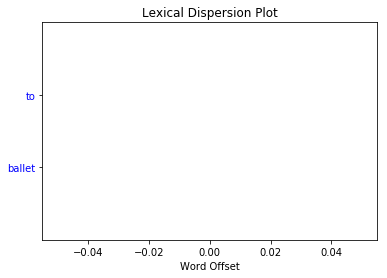

In [2180]:
nltk.draw.dispersion_plot(rev_only_one_df["clean_all_review"][1000], ["to", "ballet"])

Source: <br>
Bird, Steven, Edward Loper and Ewan Klein (2009), Natural Language Processing with Python. O’Reilly Media Inc.

In [2161]:
rev_only_one_df["tagged"] = rev_only_one_df["tokenized"].apply(nltk.pos_tag)

In [1990]:
t = Tree("S", rev_only_one_df.tagged[0][:10])

In [1991]:
t.draw()

KeyboardInterrupt: 

In [1970]:
rev_only_one_df.tagged[0]

[('i', 'NN'),
 ('had', 'VBD'),
 ('an', 'DT'),
 ('absolutely', 'RB'),
 ('amazing', 'JJ'),
 ('experience', 'NN'),
 ('in', 'IN'),
 ('victoria', 'JJ'),
 ('crutchfield', 'NN'),
 ("'s", 'POS'),
 ('gre', 'JJ'),
 ('class', 'NN'),
 (',', ','),
 ('and', 'CC'),
 ('i', 'JJ'),
 ("'m", 'VBP'),
 ('certain', 'JJ'),
 ('my', 'PRP$'),
 ('fellow', 'JJ'),
 ('classmates', 'NNS'),
 ('did', 'VBD'),
 ('as', 'RB'),
 ('well', 'RB'),
 ('.', '.'),
 ('i', 'VB'),
 ('just', 'RB'),
 ('finished', 'VBN'),
 ('my', 'PRP$'),
 ('last', 'JJ'),
 ('class', 'NN'),
 ('with', 'IN'),
 ('victoria', 'NNS'),
 ('and', 'CC'),
 ('feel', 'VB'),
 ('confident', 'JJ'),
 ('in', 'IN'),
 ('my', 'PRP$'),
 ('ability', 'NN'),
 ('attack', 'VBP'),
 ('the', 'DT'),
 ('gre', 'NN'),
 ('.', '.'),
 ('more', 'JJR'),
 ('than', 'IN'),
 ('that', 'IN'),
 (',', ','),
 ('i', 'VB'),
 ('went', 'VBD'),
 ('from', 'IN'),
 ('dreading', 'VBG'),
 ('math', 'NN'),
 ('to', 'TO'),
 ('truly', 'RB'),
 ('enjoying', 'VBG'),
 ('it', 'PRP'),
 ('thanks', 'VBZ'),
 ('to', 'TO'),
 (

In [1890]:
len(df_biz_tri.name.tolist())

1855

In [1896]:
df_biz_tri2 = df_biz_tri[df_biz_tri.name!="Bambini After School"]

In [1873]:
df_biz_tri2.drop(["index"], axis=1, inplace=True)

In [1876]:
df_biz_tri2.name[354]

'Huntington Learning Center'

In [1879]:
df_biz_tri2.name[354] == rev_only_one_df.business_name[354]

True

In [1920]:
reviews_only_df.review.tolist()

["I had an absolutely amazing experience in Victoria Crutchfield's GRE class, and I'm certain my fellow classmates did as well. I just finished my last class with Victoria and feel confident in my ability attack the GRE. More than that, I went from dreading math to truly enjoying it thanks to her enthusiasm and tutelage.  Victoria has every quality of a truly great teacher you can possibly imagine and then some - she really cares about where you're at and how to get you to where you want to be in terms of the material, strategies, and score. I started the class a decade removed from GRE level math and now fully fully confident in my ability to learn any concept and apply the strategies we learned in class to the test. She is incredibly mindful of the class's level of comfort with the material as a whole and always checks in to make sure everyone is understanding explanations, concepts, and strategies.  Highly recommended for anyone at any level. Of comfort with the material.",
 'Elaine

In [1753]:
df_all_3.head()

,display_phone,id,is_closed,name,phone,price,rating,review_count,transactions,url,...,title_1,alias_2,title_2,alias_3,title_3,title_0_code,title_1_code,title_2_code,title_3_code,counts
0,(212) 721-7400,zv-tJy03CCqZA1OZ05gJCQ,False,Manhattan Prep,+12127217400,NaN,4.5,101,[],https://www.yelp.com/biz/manhattan-prep-new-yo...,...,Test Preparation,privatetutors,Private Tutors,NaN,NaN,1,1,1,0,3
1,(212) 888-5728,HX483Djwn-9NyB2umn4LVA,False,180 Degrees LSAT,+12128885728,NaN,5.0,47,[],https://www.yelp.com/biz/180-degrees-lsat-broo...,...,Test Preparation,NaN,NaN,NaN,NaN,1,1,0,0,2
2,(646) 434-1084,6z63xLs8i0a-R1FMrzL-zw,False,Bright Kids NYC,+16464341084,NaN,3.5,34,[],https://www.yelp.com/biz/bright-kids-nyc-new-y...,...,NaN,NaN,NaN,NaN,NaN,1,0,0,0,1
4,(800) 925-7737,tiJtgi0vAQULwzVmJDankg,False,Veritas Prep,+18009257737,NaN,4.5,23,[],https://www.yelp.com/biz/veritas-prep-new-york...,...,Test Preparation,privatetutors,Private Tutors,NaN,NaN,1,1,1,0,3
5,(718) 353-9868,HTNDX9rR0ilEPIbEfTlZaQ,False,Premier Aptitude,+17183539868,NaN,5.0,13,[],https://www.yelp.com/biz/premier-aptitude-flus...,...,Tutoring Centers,NaN,NaN,NaN,NaN,1,1,0,0,2


In [ ]:
class WebScraper(object):
    
    def __init__(self, url):
        html_page = requests.get(url) #Make a get request to retrieve the page
        self.soup = BeautifulSoup(html_page.content, 'html.parser') 
    
    def get_links(cls):
        clsa